# Post-processing and visualization of Hintereisferner glacier data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series
import numpy as np
import matplotlib.dates as mdates
from collections import defaultdict
import glob

## 1. Data post-processing

In [2]:
#initialize the dictionary to contain all the data
dictionary = lambda: defaultdict(dictionary)
data_dict = dictionary()

### - Open the datasets

In [3]:
#folder pattern where all the datasets are:
folder_pattern = "/home/ciccuz/HEF_eis/data/*.dat"

#open all the different datasets and store them in one dictionary
for dataset,i in zip(sorted(glob.iglob(folder_pattern)), range(len(sorted(glob.iglob(folder_pattern))))):
    data_dict[i] = pd.read_table(dataset, sep=",", skiprows=1, index_col=0, parse_dates=True)

### - Solve eventual discrepancies among datasets: 
e.g. one dataset for midnight values has the hours written as '24' instead of '00', others?

In [4]:
#loop on the datasets
for i in range(len(data_dict.keys())):
    
    #get the actual index (i.e. timestamps):
    old_index = data_dict[i].index

    #define new index and substitute the old one:
    new_index = ["" for x in range(len(old_index))]
    
    for j in range(2,len(old_index)):
        if old_index[j][11:13] == str(24):
            list_index = list(old_index[j])
            list_index[11] = '0'
            list_index[12] = '0'
            new_index[j] = "".join(list_index)
        else:
            new_index[j] = old_index[j]
            
    #replace old dataset with new corrected one converted to datetime
    data_dict[i] = data_dict[i].set_index(pd.to_datetime(new_index, errors='coerce'))

### - Concatenate all datasets together:

In [5]:
df = pd.DataFrame()
for i in range(len(data_dict.keys())):
    df = pd.concat([df, data_dict[i].iloc[2:]])
df.index = pd.to_datetime(df.index)
dates = df.index

### - Compute e.g. monthly averages for the variables of interest:

In [6]:
#list of the variables to consider:
variables = ['RH_Avg', 'e_Avg', 'Tair_Avg', 'Tair_Max', 'Tair_Min', 'Wdir', 'Wspeed', 'SWI_Avg', 'SWO_Avg', 
            'LWI_corr_Avg', 'LWO_corr_Avg', 'Press', 'Dist_Avg']

#compute monthly means for each variable and save them in a dataframe:
df_mm = pd.DataFrame(columns=variables)
for v in variables:
    df_mm[v] = pd.to_numeric(df[v], errors='coerce').resample('MS').mean()

## 2. Plotting

### - 2-variables plot

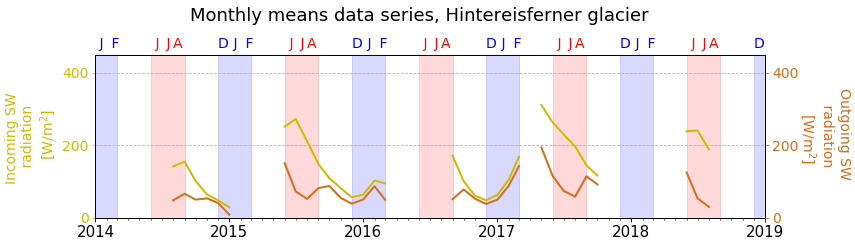

In [32]:
#preliminary parameters:
lw=2

datemin = np.datetime64(dates[0], 'Y')
datemax = np.datetime64(dates[-1], 'Y')+ np.timedelta64(1, 'Y')


#PLOT: 
fig, ax1 = plt.subplots(1, 1, figsize=(12,3))

fig.subplots_adjust(hspace=0.0)
fig.suptitle('Monthly means data series, Hintereisferner glacier', fontsize=18, y=1.1)

"""
INCOMING & OUTGOING SW RADIATION
"""
ax1 = plt.subplot2grid((1,1), (0,0), rowspan=1, colspan=1)

#set the locators for the ticks in the x-axis: major locator are the years, minor locators the months
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(yearsFmt)
ax1.xaxis.set_minor_locator(months)
ax1.set_xlim(datemin, datemax)

#set ticks properties on x-axis
ax1.xaxis.set_ticks_position('none')
ax1.tick_params(axis='x', labelsize=0)
ax1.set_xticks([])

#set the time range on the x-axis
ax1.set_xlim(datemin, datemax)

#plot data time-series
ax1.plot(df_mm.index, df_mm.SWI_Avg, label='SWI_Avg', color='#D2B900', lw=lw)

#set some features: labels, ticks, legend
ax1.set_ylabel('Incoming SW \n radiation \n [W/m$^2$]', color='#D2B900')
ax1.set_yticks(np.arange(0,1001,200))
ax1.tick_params(axis='y', colors='#D2B900')
ax1.set_ylim(0, 450)


#ax2:share x-axis with ax1
ax2 = ax1.twinx()
ax2.plot(df_mm.index, df_mm.SWO_Avg, label='SWO_Avg', color='#D66D1A', lw=lw)
                          
ax2.set_ylabel('Outgoing SW \n radiation \n [W/m$^2$]', color='#D66D1A', rotation=-90, labelpad=50)
ax2.tick_params(axis='y', colors='#D66D1A')
ax2.set_yticks(np.arange(0,1001,200))
ax2.set_ylim(0, 450)
ax2.xaxis.set_ticks_position('none')
ax2.get_xaxis().set_visible(False)
ax2.yaxis.grid(True, which='major', linestyle='--')

#PLOT BACKGROUND COLOURED BARS TO INDICATE JJA AND DJF SEASONS:
daterange = pd.date_range('2013-01-01', '2020-03-01', freq='MS')
alpha=0.15

for year in [2013,2014,2015,2016,2017,2018]:
    subindex = daterange[daterange.year==year]
    subindex_year1 = daterange[daterange.year==year+1]
    
    #JJA
    ax1.axvspan(subindex[subindex.month==6], subindex[subindex.month==9], alpha=alpha, color='red')
    
    #DJF
    ax1.axvspan(subindex[subindex.month==12], subindex_year1[subindex_year1.month==3], alpha=alpha, color='blue')
    
#ADD UPPER AXIS TO SHOW THE SEASONS
ax1top = ax1.twiny()
ax1top.xaxis.set_minor_locator(months)
ax1top.set_xlim(datemin, datemax)

#get xticks positions:
xticks = ax1top.get_xticks(minor=True)

#write the summer and winter ticks labels separately
wint_ticks = np.concatenate((xticks[0:2], xticks[11:14], xticks[23:26], xticks[35:38], xticks[47:50], xticks[59]),
                           axis=None)

summ_ticks = np.concatenate((xticks[5:8], xticks[17:20], xticks[29:32], xticks[41:44], xticks[53:56]),
                           axis=None)

ticks_conc = np.concatenate((summ_ticks, wint_ticks), axis=None)

#set the new set of ticks
ax1top.set_xticks(ticks_conc)

#change ticks labels with name of months, their colors and positions
xticks_labels = [item.get_text() for item in ax1top.get_xticklabels()]

for i in range(15):
    xticks_labels[i] = ' J'
    ax1top.xaxis.get_majorticklabels()[i].set_horizontalalignment("left")
    ax1top.get_xticklabels()[i].set_color('red')
for i in [2,5,8,11,14]:
    xticks_labels[i] = 'A'

for i in range(15,30):
    xticks_labels[i] = ' J'
    ax1top.xaxis.get_majorticklabels()[i].set_horizontalalignment("left")
    ax1top.get_xticklabels()[i].set_color('blue')
for i in [16, 19, 22, 25, 28]:
    xticks_labels[i] = ' F'
for i in [17, 20, 23, 26, 29]:
    xticks_labels[i] = 'D'    

ax1top.set_xticklabels(xticks_labels)
ax1top.xaxis.set_tick_params(labelsize=14)

#remove ticks lines, keep just the labels
ax1top.tick_params(axis=u'both', which=u'both',length=0)

plt.rcParams.update({'font.size': 14})

### - 4-variables plot

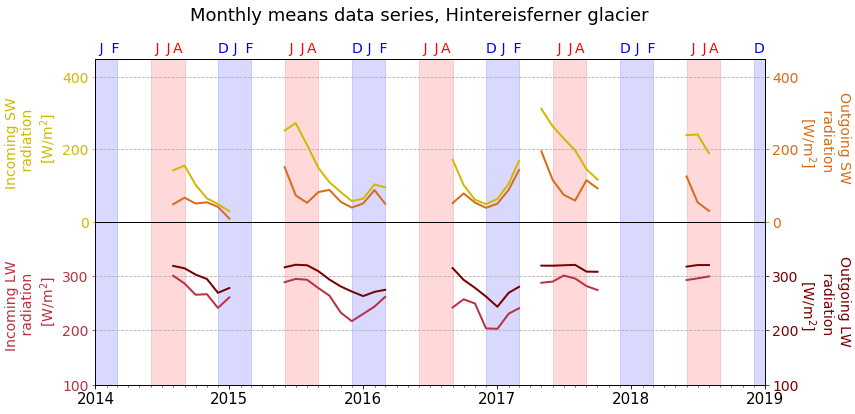

In [40]:
#preliminary parameters:
lw=2

datemin = np.datetime64(dates[0], 'Y')
datemax = np.datetime64(dates[-1], 'Y')+ np.timedelta64(1, 'Y')


#PLOT: 
fig, ax1 = plt.subplots(2, 1, figsize=(12,6))

fig.subplots_adjust(hspace=0.0)
fig.suptitle('Monthly means data series, Hintereisferner glacier', fontsize=18, y=1)

"""
INCOMING & OUTGOING SW RADIATION
"""
ax1 = plt.subplot2grid((2,1), (0,0), rowspan=1, colspan=1)

#set the locators for the ticks in the x-axis: major locator are the years, minor locators the months
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(yearsFmt)
ax1.xaxis.set_minor_locator(months)
ax1.set_xlim(datemin, datemax)

#set ticks properties on x-axis
ax1.xaxis.set_ticks_position('none')
ax1.tick_params(axis='x', labelsize=0)
ax1.set_xticks([])

#set the time range on the x-axis
ax1.set_xlim(datemin, datemax)

#plot data time-series
ax1.plot(df_mm.index, df_mm.SWI_Avg, label='SWI_Avg', color='#D2B900', lw=lw)

#set some features: labels, ticks, legend
ax1.set_ylabel('Incoming SW \n radiation \n [W/m$^2$]', color='#D2B900')
ax1.set_yticks(np.arange(0,1001,200))
ax1.tick_params(axis='y', colors='#D2B900')
ax1.set_ylim(0, 450)
ax1.tick_params(axis='x', labelsize=15, which='major')
ax1.xaxis.set_ticks_position('none')
ax1.get_xaxis().set_visible(False)

#ax2:share x-axis with ax1
ax2 = ax1.twinx()
ax2.plot(df_mm.index, df_mm.SWO_Avg, label='SWO_Avg', color='#D66D1A', lw=lw)
                          
ax2.set_ylabel('Outgoing SW \n radiation \n [W/m$^2$]', color='#D66D1A', rotation=-90, labelpad=50)
ax2.tick_params(axis='y', colors='#D66D1A')
ax2.set_yticks(np.arange(0,1001,200))
ax2.set_ylim(0, 450)
ax2.xaxis.set_ticks_position('none')
ax2.get_xaxis().set_visible(False)
ax2.yaxis.grid(True, which='major', linestyle='--')

"""
INCOMING & OUTGOING LW RADIATION
"""
ax3 = plt.subplot2grid((2,1), (1,0), rowspan=1, colspan=1)

ax3.xaxis.set_major_locator(years)
ax3.xaxis.set_major_formatter(yearsFmt)
ax3.xaxis.set_minor_locator(months)
ax3.set_xlim(datemin, datemax)
ax3.tick_params(axis='x', labelsize=15, which='major')

ax3.plot(df_mm.index, df_mm.LWI_corr_Avg, label='LWI_Avg', color='#B83242', lw=lw)

ax3.set_ylabel('Incoming LW \n radiation \n [W/m$^2$]', color='#B83242')
ax3.set_yticks(np.arange(100,400,100))
ax3.tick_params(axis='y', colors='#B83242')
ax3.set_ylim(100, 400)

ax4 = ax3.twinx()
ax4.plot(df_mm.index, df_mm.LWO_corr_Avg, label='LWO_Avg', color='#780000', lw=lw)
                          
ax4.set_ylabel('Outgoing LW \n radiation \n [W/m$^2$]', color='#780000', rotation=-90, labelpad=50)
ax4.tick_params(axis='y', colors='#780000')
ax4.set_yticks(np.arange(100,400,100))
ax4.set_ylim(100, 400)
ax3.yaxis.grid(True, which='major', linestyle='--')


#PLOT BACKGROUND COLOURED BARS TO INDICATE JJA AND DJF SEASONS:
daterange = pd.date_range('2013-01-01', '2020-03-01', freq='MS')
alpha=0.15

for year in [2013,2014,2015,2016,2017,2018]:
    subindex = daterange[daterange.year==year]
    subindex_year1 = daterange[daterange.year==year+1]
    
    #JJA
    ax1.axvspan(subindex[subindex.month==6], subindex[subindex.month==9], alpha=alpha, color='red')
    ax3.axvspan(subindex[subindex.month==6], subindex[subindex.month==9], alpha=alpha, color='red')
    
    #DJF
    ax1.axvspan(subindex[subindex.month==12], subindex_year1[subindex_year1.month==3], alpha=alpha, color='blue')
    ax3.axvspan(subindex[subindex.month==12], subindex_year1[subindex_year1.month==3], alpha=alpha, color='blue')
    
#ADD UPPER AXIS TO SHOW THE SEASONS
ax1top = ax1.twiny()
ax1top.xaxis.set_minor_locator(months)
ax1top.set_xlim(datemin, datemax)

#get xticks positions:
xticks = ax1top.get_xticks(minor=True)

#write the summer and winter ticks labels separately
wint_ticks = np.concatenate((xticks[0:2], xticks[11:14], xticks[23:26], xticks[35:38], xticks[47:50], xticks[59]),
                           axis=None)

summ_ticks = np.concatenate((xticks[5:8], xticks[17:20], xticks[29:32], xticks[41:44], xticks[53:56]),
                           axis=None)

ticks_conc = np.concatenate((summ_ticks, wint_ticks), axis=None)

#set the new set of ticks
ax1top.set_xticks(ticks_conc)

#change ticks labels with name of months, their colors and positions
xticks_labels = [item.get_text() for item in ax1top.get_xticklabels()]

for i in range(15):
    xticks_labels[i] = ' J'
    ax1top.xaxis.get_majorticklabels()[i].set_horizontalalignment("left")
    ax1top.get_xticklabels()[i].set_color('red')
for i in [2,5,8,11,14]:
    xticks_labels[i] = 'A'

for i in range(15,30):
    xticks_labels[i] = ' J'
    ax1top.xaxis.get_majorticklabels()[i].set_horizontalalignment("left")
    ax1top.get_xticklabels()[i].set_color('blue')
for i in [16, 19, 22, 25, 28]:
    xticks_labels[i] = ' F'
for i in [17, 20, 23, 26, 29]:
    xticks_labels[i] = 'D'    

ax1top.set_xticklabels(xticks_labels)
ax1top.xaxis.set_tick_params(labelsize=14)

#remove ticks lines, keep just the labels
ax1top.tick_params(axis=u'both', which=u'both',length=0)

plt.rcParams.update({'font.size': 14})

### - one comprehensive plot of all the variables:

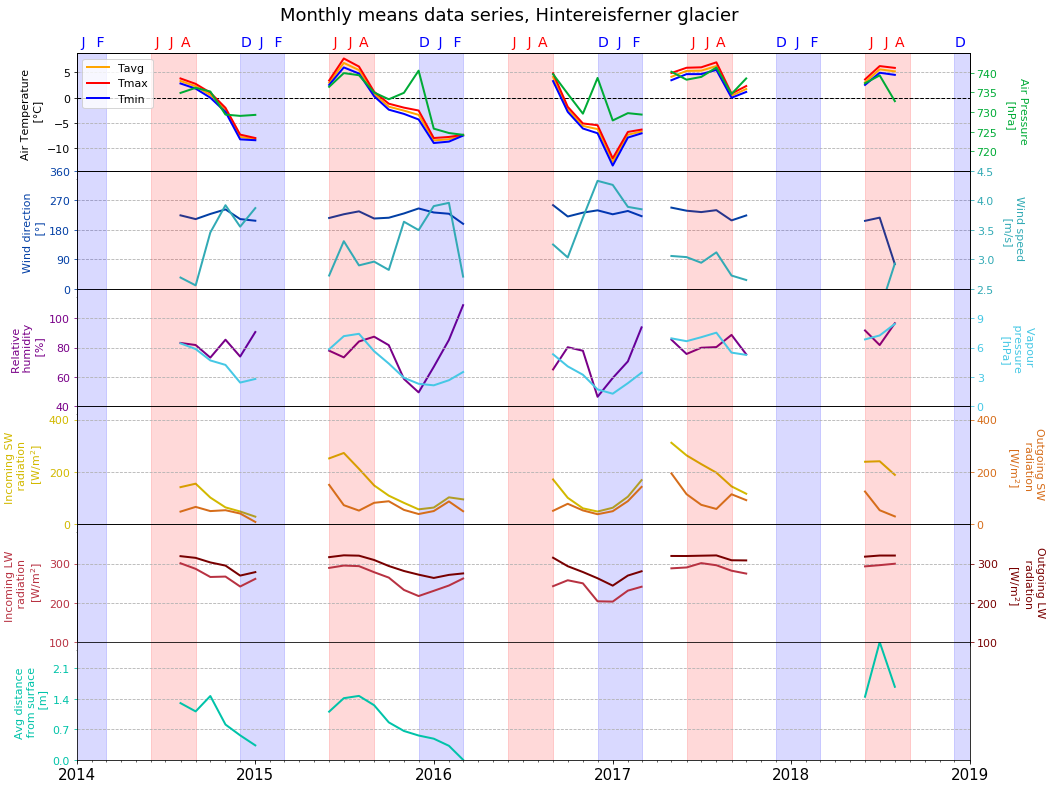

In [47]:
#preliminary parameters:
lw=2

datemin = np.datetime64(dates[0], 'Y')
datemax = np.datetime64(dates[-1], 'Y')+ np.timedelta64(1, 'Y')


#PLOT: formed by 6 subplots sharing the x-axis

fig, (ax1, ax2, ax4, ax6, ax8, ax10) = plt.subplots(6, 1, figsize=(16,13))

fig.subplots_adjust(hspace=0.0)
fig.suptitle('Monthly means data series, Hintereisferner glacier', fontsize=18, y=0.93)


"""
TEMPERATURE & PRESSURE
"""
ax1 = plt.subplot2grid((6,1), (0,0), rowspan=1, colspan=1)

#set the locators for the ticks in the x-axis: major locator are the years, minor locators the months
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')
ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(yearsFmt)
ax1.xaxis.set_minor_locator(months)

#set the time range on the x-axis
ax1.set_xlim(datemin, datemax)

#plot the monthly-mean time series
ax1.plot(df_mm.index, df_mm.Tair_Avg, label='Tavg', color='orange', lw=lw)
ax1.plot(df_mm.index, df_mm.Tair_Max, label='Tmax', color='red', lw=lw)
ax1.plot(df_mm.index, df_mm.Tair_Min, label='Tmin', color='blue', lw=lw)

#plot a horizontal dashed line to indicate the 0°C value
ax1.hlines(y=0, xmin=datemin, xmax=datemax, linewidth=1, color='black', linestyle='--')

#set some features: labels, ticks, legend
ax1.set_ylabel('Air Temperature \n [°C]')
ax1.xaxis.set_ticks_position('none')
ax1.tick_params(axis='x', labelsize=0)
ax1.set_yticks(np.arange(-10, round(max(df_mm.Tair_Max))+2, 5))
ax1.legend()
ax1.yaxis.grid(True, which='major', linestyle='--')

#share the x-axis to represent also another variable within the same plot
ax1_1 = ax1.twinx()
ax1_1.plot(df_mm.index, df_mm.Press, label='Press', color='#00AB36', lw=lw)

#set some features: labels, ticks, legend
ax1_1.set_ylabel('Air Pressure \n [hPa]', color='#00AB36', rotation=-90, labelpad=30)
ax1_1.tick_params(axis='y', colors='#00AB36')
ax1_1.set_yticks(np.arange(720, 745, 5))
ax1_1.xaxis.set_ticks_position('none')
ax1_1.get_xaxis().set_visible(False)
ax1_1.set_ylim(715,745)


"""
WIND SPEED & DIRECTION
"""
ax2 = plt.subplot2grid((6,1), (1,0), rowspan=1, colspan=1)

ax2.xaxis.set_ticks_position('none')
ax2.tick_params(axis='x', labelsize=0)

ax2.set_xlim(datemin, datemax)

ax2.plot(df_mm.index, df_mm.Wdir, label='Wdir', color='#023FA5', lw=lw)
ax2.set_ylabel('Wind direction \n [°]', color='#023FA5')
ax2.set_yticks(np.arange(0, 360+1, 90))
ax2.set_ylim(0,360)

ax2.tick_params(axis='y', colors='#023FA5')

ax3 = ax2.twinx()
ax3.plot(df_mm.index, df_mm.Wspeed, label='Wspeed', color='#32AAB5', lw=lw)

ax3.set_ylabel('Wind speed \n [m/s]', color='#32AAB5', rotation=-90, labelpad=30)
ax3.tick_params(axis='y', colors='#32AAB5')
ax3.set_yticks(np.arange(round(min(df_mm.Wspeed))-0.5, round(max(df_mm.Wspeed))+1, 0.5))
ax3.xaxis.set_ticks_position('none')
ax3.get_xaxis().set_visible(False)
ax3.set_ylim(2.5,4.5)
ax2.yaxis.grid(True, which='major', linestyle='--')


"""
RELATIVE HUMIDITY & VAPOUR PRESSURE
"""
ax4 = plt.subplot2grid((6,1), (2,0), rowspan=1, colspan=1)

ax4.xaxis.set_major_locator(years)
ax4.xaxis.set_major_formatter(yearsFmt)
ax4.xaxis.set_minor_locator(months)
ax4.set_xlim(datemin, datemax)
ax4.xaxis.set_ticks_position('none')
ax4.tick_params(axis='x', labelsize=0)
ax4.set_ylim(40,120)

ax4.plot(df_mm.index, df_mm.RH_Avg, label='RHavg', color='#790088', lw=lw)

ax4.set_ylabel('Relative \n humidity \n [%]', color='#790088')
ax4.set_yticks(np.arange(40, 110, 20))
ax4.tick_params(axis='y', colors='#790088')
                
ax5 = ax4.twinx()
ax5.plot(df_mm.index, df_mm.e_Avg, label='eAvg', color='#46C8E5', lw=lw)

ax5.set_ylabel('Vapour \n pressure \n [hPa]', color='#46C8E5', rotation=-90, labelpad=50)
ax5.tick_params(axis='y', colors='#46C8E5')
ax5.set_yticks(np.arange(0, 10, 3))
ax5.set_ylim(0,12)
ax5.xaxis.set_ticks_position('none')
ax5.get_xaxis().set_visible(False)
ax5.yaxis.grid(True, which='major', linestyle='--')


"""
INCOMING & OUTGOING SW RADIATION
"""
ax6 = plt.subplot2grid((6,1), (3,0), rowspan=1, colspan=1)

ax6.xaxis.set_major_locator(years)
ax6.xaxis.set_major_formatter(yearsFmt)
ax6.xaxis.set_minor_locator(months)
ax6.set_xlim(datemin, datemax)
ax6.xaxis.set_ticks_position('none')
ax6.tick_params(axis='x', labelsize=0)
ax6.set_xticks([])

ax6.plot(df_mm.index, df_mm.SWI_Avg, label='SWI_Avg', color='#D2B900', lw=lw)

ax6.set_ylabel('Incoming SW \n radiation \n [W/m$^2$]', color='#D2B900')
ax6.set_yticks(np.arange(0,1001,200))
ax6.tick_params(axis='y', colors='#D2B900')
ax6.set_ylim(0, 450)

ax7 = ax6.twinx()
ax7.plot(df_mm.index, df_mm.SWO_Avg, label='SWO_Avg', color='#D66D1A', lw=lw)
                          
ax7.set_ylabel('Outgoing SW \n radiation \n [W/m$^2$]', color='#D66D1A', rotation=-90, labelpad=45)
ax7.tick_params(axis='y', colors='#D66D1A')
ax7.set_yticks(np.arange(0,1001,200))
ax7.set_ylim(0, 450)
ax7.xaxis.set_ticks_position('none')
ax7.get_xaxis().set_visible(False)
ax7.yaxis.grid(True, which='major', linestyle='--')


"""
INCOMING & OUTGOING LW RADIATION
"""
ax8 = plt.subplot2grid((6,1), (4,0), rowspan=1, colspan=1)

ax8.xaxis.set_major_locator(years)
ax8.xaxis.set_major_formatter(yearsFmt)
ax8.xaxis.set_minor_locator(months)
ax8.set_xlim(datemin, datemax)
ax8.tick_params(axis='x', labelsize=0)

ax8.plot(df_mm.index, df_mm.LWI_corr_Avg, label='LWI_Avg', color='#B83242', lw=lw)

ax8.set_ylabel('Incoming LW \n radiation \n [W/m$^2$]', color='#B83242')
ax8.set_yticks(np.arange(100,400,100))
ax8.tick_params(axis='y', colors='#B83242')
ax8.set_ylim(100, 400)

ax9 = ax8.twinx()
ax9.plot(df_mm.index, df_mm.LWO_corr_Avg, label='LWO_Avg', color='#780000', lw=lw)
                          
ax9.set_ylabel('Outgoing LW \n radiation \n [W/m$^2$]', color='#780000', rotation=-90, labelpad=45)
ax9.tick_params(axis='y', colors='#780000')
ax9.set_yticks(np.arange(100,400,100))
ax9.set_ylim(100, 400)
ax8.yaxis.grid(True, which='major', linestyle='--')


"""
DISTANCE FROM GLACIER SURFACE
"""
ax10 = plt.subplot2grid((6,1), (5,0), rowspan=1, colspan=1)

ax10.xaxis.set_major_locator(years)
ax10.xaxis.set_major_formatter(yearsFmt)
ax10.xaxis.set_minor_locator(months)
ax10.set_xlim(datemin, datemax)
ax10.tick_params(axis='x', labelsize=15, which='major')

ax10.plot(df_mm.index, df_mm.Dist_Avg, label='Dist_Avg', color='#00C3A9', lw=lw)

ax10.set_ylabel('Avg distance \n from surface \n [m]', color='#00C3A9')
ax10.set_yticks(np.arange(0,2.75,0.7))
ax10.tick_params(axis='y', colors='#00C3A9')
ax10.set_ylim(0, 2.7)
ax10.yaxis.grid(True, which='major', linestyle='--')




#PLOT BACKGROUND COLOURED BARS TO INDICATE JJA AND DJF SEASONS:
daterange = pd.date_range('2013-01-01', '2020-03-01', freq='MS')
alpha=0.15

for year in [2013,2014,2015,2016,2017,2018]:
    subindex = daterange[daterange.year==year]
    subindex_year1 = daterange[daterange.year==year+1]
    
    #JJA
    ax10.axvspan(subindex[subindex.month==6], subindex[subindex.month==9], alpha=alpha, color='red')
    ax8.axvspan(subindex[subindex.month==6], subindex[subindex.month==9], alpha=alpha, color='red')
    ax7.axvspan(subindex[subindex.month==6], subindex[subindex.month==9], alpha=alpha, color='red')
    ax5.axvspan(subindex[subindex.month==6], subindex[subindex.month==9], alpha=alpha, color='red')
    ax3.axvspan(subindex[subindex.month==6], subindex[subindex.month==9], alpha=alpha, color='red')
    ax1.axvspan(subindex[subindex.month==6], subindex[subindex.month==9], alpha=alpha, color='red')
    
    #DJF
    ax10.axvspan(subindex[subindex.month==12], subindex_year1[subindex_year1.month==3], alpha=alpha, color='blue')
    ax8.axvspan(subindex[subindex.month==12], subindex_year1[subindex_year1.month==3], alpha=alpha, color='blue')
    ax7.axvspan(subindex[subindex.month==12], subindex_year1[subindex_year1.month==3], alpha=alpha, color='blue')
    ax5.axvspan(subindex[subindex.month==12], subindex_year1[subindex_year1.month==3], alpha=alpha, color='blue')
    ax3.axvspan(subindex[subindex.month==12], subindex_year1[subindex_year1.month==3], alpha=alpha, color='blue')
    ax1.axvspan(subindex[subindex.month==12], subindex_year1[subindex_year1.month==3], alpha=alpha, color='blue')
    
#ADD UPPER AXIS TO SHOW THE SEASONS
ax1top = ax1.twiny()
ax1top.xaxis.set_minor_locator(months)
ax1top.set_xlim(datemin, datemax)

#get xticks positions:
xticks = ax1top.get_xticks(minor=True)

#write the summer and winter ticks labels separately
wint_ticks = np.concatenate((xticks[0:2], xticks[11:14], xticks[23:26], xticks[35:38], xticks[47:50], xticks[59]),
                           axis=None)

summ_ticks = np.concatenate((xticks[5:8], xticks[17:20], xticks[29:32], xticks[41:44], xticks[53:56]),
                           axis=None)

ticks_conc = np.concatenate((summ_ticks, wint_ticks), axis=None)

#set the new set of ticks
ax1top.set_xticks(ticks_conc)

#change ticks labels with name of months, their colors and positions
xticks_labels = [item.get_text() for item in ax1top.get_xticklabels()]

for i in range(15):
    xticks_labels[i] = ' J'
    ax1top.xaxis.get_majorticklabels()[i].set_horizontalalignment("left")
    ax1top.get_xticklabels()[i].set_color('red')
for i in [2,5,8,11,14]:
    xticks_labels[i] = 'A'

for i in range(15,30):
    xticks_labels[i] = ' J'
    ax1top.xaxis.get_majorticklabels()[i].set_horizontalalignment("left")
    ax1top.get_xticklabels()[i].set_color('blue')
for i in [16, 19, 22, 25, 28]:
    xticks_labels[i] = ' F'
for i in [17, 20, 23, 26, 29]:
    xticks_labels[i] = 'D'    

ax1top.set_xticklabels(xticks_labels)
ax1top.xaxis.set_tick_params(labelsize=14)

#remove ticks lines, keep just the labels
ax1top.tick_params(axis=u'both', which=u'both',length=0)

plt.rcParams.update({'font.size': 11})


### - Data quality control:

detect the flags on raw data indicating when the sensors are not properly working, consequently producing wrong data or no data at all, in order to produce some automatic corrections. These include:
- Wind sensors (05103/05103LM, 05305 & 05106, Campbell Scientific): 
    - wind direction: -9999 or constant wind direction, 
    - wind speed: no wind speed
- Temperature and Relative Humidity Probe (HMP45C, Campbell Scientific):
    - temperature: -9999, NAN, -40 deg C
    - relative humidity: 0% or >100%
- Sonic ranger sensor (SR50A/AT, Campbell Scientific): -999, NAN. When buried in snow: 0.0


- Radiometer (CNR 4, Kipp & Zonen): ??
- Air pressure (PTB110, Vaisala): ?? 

In [176]:
#Detect the subset of data where sensors show wrong estimates:
RH_malfunct = df.RH_Avg.loc[(df.RH_Avg.values.astype(np.float) >= 100.0) | 
                            (df.RH_Avg.values.astype(np.float) == 0.0)]

Tair_malfunct = df.Tair_Avg.loc[(df.Tair_Avg.values.astype(np.float) == -9999) | 
                                (df.Tair_Avg.values.astype(np.float) == -40.0) |
                                (df.Tair_Avg.values.astype(np.float) == np.nan) |
                                (df.Tair_Avg == 'NAN')]

Wdir_malfunct = df.Wdir.loc[(df.Wdir.values.astype(np.float) == -9999)]
Wspeed_malfunct = df.Wspeed.loc[(df.Wspeed.values.astype(np.float) == np.nan) |
                               (df.Wspeed == 'NAN')]

SR_malfunct = df.Dist_Avg.loc[(df.Dist_Avg.values.astype(np.float) == -999) |
                              (df.Dist_Avg.values.astype(np.float) == np.nan) |
                              (df.Dist_Avg == 'NAN') |
                              (df.Dist_Avg.values.astype(np.float) == 0.0)]

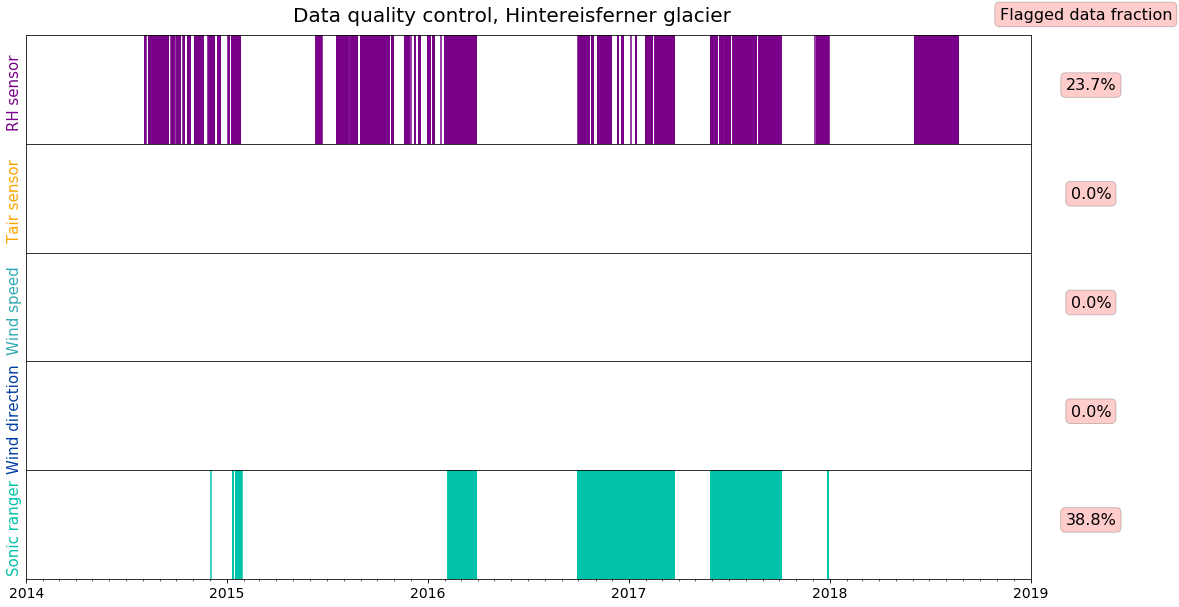

In [178]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1, figsize=(18,10))

fig.subplots_adjust(hspace=0.0)
fig.suptitle('Data quality control, Hintereisferner glacier', fontsize=20, y=0.92)

"""
Relative humidity
"""
ax1 = plt.subplot2grid((5,1), (0,0), rowspan=1, colspan=1)

#write the column title for percentage of the total data affected by errors    
ax1.text(x=1.055,y=1.15, s='Flagged data fraction', fontsize=16, horizontalalignment='center',
         transform=ax1.transAxes, bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))


#set the locators for the ticks in the x-axis: major locator are the years, minor locators the months
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax1.xaxis.set_major_locator(years)
ax1.xaxis.set_major_formatter(yearsFmt)
ax1.xaxis.set_minor_locator(months)
ax1.set_xlim(datemin, datemax)

#set the time range on the x-axis
ax1.set_xlim(datemin, datemax)

#plot vertical lines where wrong estimations of the variables are present
for x in RH_malfunct.index.values:
    ax1.axvline(x=x, color='#790088')

#write the percentage of the total data affected by errors    
ax1.text(x=1.06,y=0.5, s=f'{len(RH_malfunct)/len(df.RH_Avg)*100:.1f}%', fontsize=16, horizontalalignment='center', 
         transform=ax1.transAxes, bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))
    
#set some features: labels, ticks, legend
ax1.set_ylabel('RH sensor ', color='#790088', fontsize=15)
ax1.set_yticks([]);
ax1.xaxis.set_ticks_position('none')
ax1.get_xaxis().set_visible(False)



"""
Temperature
"""
ax2 = plt.subplot2grid((5,1), (1,0), rowspan=1, colspan=1)

#set the locators for the ticks in the x-axis: major locator are the years, minor locators the months
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax2.xaxis.set_major_locator(years)
ax2.xaxis.set_major_formatter(yearsFmt)
ax2.xaxis.set_minor_locator(months)
ax2.set_xlim(datemin, datemax)

#set the time range on the x-axis
ax2.set_xlim(datemin, datemax)

#plot vertical lines where wrong estimations of the variables are present
for x in Tair_malfunct.index.values:
    ax2.axvline(x=x, color='orange')

#write the percentage of the total data affected by errors    
ax2.text(x=1.06,y=0.5, s=f'{len(Tair_malfunct)/len(df.Tair_Avg)*100:.1f}%', fontsize=16, horizontalalignment='center',
         transform=ax2.transAxes, bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))
    
#set some features: labels, ticks, legend
ax2.set_ylabel('Tair sensor ', color='orange', fontsize=15)
ax2.set_yticks([]);
ax2.xaxis.set_ticks_position('none')
ax2.get_xaxis().set_visible(False)


"""
Wind speed
"""
ax3 = plt.subplot2grid((5,1), (2,0), rowspan=1, colspan=1)

#set the locators for the ticks in the x-axis: major locator are the years, minor locators the months
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax3.xaxis.set_major_locator(years)
ax3.xaxis.set_major_formatter(yearsFmt)
ax3.xaxis.set_minor_locator(months)
ax3.set_xlim(datemin, datemax)

#set the time range on the x-axis
ax3.set_xlim(datemin, datemax)

#plot vertical lines where wrong estimations of the variables are present
for x in Wspeed_malfunct.index.values:
    ax3.axvline(x=x, color='#32AAB5')

#write the percentage of the total data affected by errors    
ax3.text(x=1.06,y=0.5, s=f'{len(Wspeed_malfunct)/len(df.Wspeed)*100:.1f}%', fontsize=16, horizontalalignment='center', 
         transform=ax3.transAxes, bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))
    
#set some features: labels, ticks, legend
ax3.set_ylabel('Wind speed ', color='#32AAB5', fontsize=15)
ax3.set_yticks([]);
ax3.xaxis.set_ticks_position('none')
ax3.get_xaxis().set_visible(False)


"""
Wind direction
"""
ax4 = plt.subplot2grid((5,1), (3,0), rowspan=1, colspan=1)

#set the locators for the ticks in the x-axis: major locator are the years, minor locators the months
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax4.xaxis.set_major_locator(years)
ax4.xaxis.set_major_formatter(yearsFmt)
ax4.xaxis.set_minor_locator(months)
ax4.set_xlim(datemin, datemax)

#set the time range on the x-axis
ax4.set_xlim(datemin, datemax)

#plot vertical lines where wrong estimations of the variables are present
for x in Wdir_malfunct.index.values:
    ax4.axvline(x=x, color='#023FA5')

#write the percentage of the total data affected by errors    
ax4.text(x=1.06,y=0.5, s=f'{len(Wdir_malfunct)/len(df.Wdir)*100:.1f}%', fontsize=16, horizontalalignment='center',
         transform=ax4.transAxes, bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))
    
#set some features: labels, ticks, legend
ax4.set_ylabel('Wind direction ', color='#023FA5', fontsize=15)
ax4.set_yticks([]);
ax4.xaxis.set_ticks_position('none')
ax4.get_xaxis().set_visible(False)


"""
Sonic ranger
"""
ax5 = plt.subplot2grid((5,1), (4,0), rowspan=1, colspan=1)

#set the locators for the ticks in the x-axis: major locator are the years, minor locators the months
years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
yearsFmt = mdates.DateFormatter('%Y')

ax5.xaxis.set_major_locator(years)
ax5.xaxis.set_major_formatter(yearsFmt)
ax5.xaxis.set_minor_locator(months)
ax5.set_xlim(datemin, datemax)

#set the time range on the x-axis
ax5.set_xlim(datemin, datemax)

#plot vertical lines where wrong estimations of the variables are present
for x in SR_malfunct.index.values:
    ax5.axvline(x=x, color='#00C3A9')

#write the percentage of the total data affected by errors    
ax5.text(x=1.06,y=0.5, s=f'{len(SR_malfunct)/len(df.Dist_Avg)*100:.1f}%', fontsize=16, horizontalalignment='center', 
         transform=ax5.transAxes, bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))
    
#set some features: labels, ticks, legend
ax5.set_ylabel('Sonic ranger ', color='#00C3A9', fontsize=15)
ax5.set_yticks([]);


plt.rcParams.update({'font.size': 14})